# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sale_apart = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
sale_apart.info() 
date = '%Y-%m-%d'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Пандас ограничил количество столбцов, которые показываются у датафрейма. Чтобы узнать чему оно равно можно выполнить pd.options.display.max_columns. Поэтому мы сразу изменили это значение и нам открылись два столбца studio и open_plan.

In [3]:
pd.options.display.max_columns = 50
pd.options.display.max_columns

50

In [4]:
display(sale_apart.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Узнаем количество пропусков в процентах. Только почему то 9% и 8% идет после 88%. Не пойму, что не так.

In [5]:
per_nan = pd.DataFrame({'percent_of_nan': sale_apart.isnull().sum()/len(sale_apart)})
per_nan['percent_of_nan'] = per_nan['percent_of_nan'].map(lambda x:'{:.2%}'.format(x))
per_nan.sort_values(by='percent_of_nan', ascending=False)

,percent_of_nan
kitchen_area,9.61%
is_apartment,88.29%
living_area,8.03%
parks_nearest,65.91%
ponds_nearest,61.56%
balcony,48.61%
ceiling_height,38.80%
airports_nearest,23.38%
cityCenters_nearest,23.29%
ponds_around3000,23.28%


**Вывод**

После первого изучения данных из файла было обаружено, что значения из всех столбцов слились в один. Был указан как разделитель знак табуляции: '\t'. После чего все данные встали на свои места. Таблица состоит из 22 столбцов и 23699 строк.
Были обнаружены пропуски в таких переменных как:

- ceiling_height — высота потолков (м), 38% пропусков 

- floors_total — всего этажей в доме, должен быть тип int, так как количество этажей - целое значение, 0.36% пропусков

- living_area — жилая площадь в квадратных метрах(м²), 8% пропусков 

- is_apartment — апартаменты (булев тип),  должен быть тип bool, 88% пропусков

- kitchen_area — площадь кухни в квадратных метрах (м²), 9% пропусков

- balcony — число балконов, заменить тип данных на int, 48% пропусков

- locality_name — название населённого пункта, 0.26% пропусков

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м), 23% пропусков 

- cityCenters_nearest — расстояние до центра города (м), 23% пропусков

- parks_around3000 — число парков в радиусе 3 км, тип должен быть int, 23% пропусков

- parks_nearest — расстояние до ближайшего парка (м), 65% пропусков

- ponds_nearest - расстояние до ближайшего водоёма (м), 61% пропусков 

- ponds_around3000 — число водоёмов в радиусе 3 км, тип должен быть int, 23% пропусков

- days_exposition — сколько дней было размещено объявление (от публикации до снятия), тип должен быть int, 13% пропусков 

- last_price - цена на момент снятия с публикации, тип должен быть int, чтобы не запутаться в десятичных и сотых.



Идем обрабатывать эту большую кучу пропусков.

## Предобработка данных

Проверяем все интересующие нас столбцы на наличие ошибок и артефактов.

In [6]:
sale_apart['total_images'].value_counts()
sale_apart['ceiling_height'].value_counts()
sale_apart['floor'].value_counts()
sale_apart['is_apartment'].value_counts()
sale_apart['total_area'].value_counts()
sale_apart['rooms'].value_counts()
sale_apart['airports_nearest'].value_counts()
sale_apart['cityCenters_nearest'].value_counts()
sale_apart['parks_around3000'].value_counts()
sale_apart['parks_nearest'].value_counts()
sale_apart['ponds_around3000'].value_counts()

0.0    9071
1.0    5717
2.0    1892
3.0    1501
Name: ponds_around3000, dtype: int64

Проверяем таблицу на дубликаты

In [7]:
sale_apart.duplicated().sum()

0

Проверим столбец 'locality_name' на артефакты из-за возможного разного регистра.

In [8]:
#print(sale_apart['locality_name'].unique())

Один и тот же населенный пункт написан по разному - поселок, посёлок, село. Попробуем избавиться от этой ошибки и избавиться в принципе от типов населенных пунктов.   

In [9]:
sale_apart['locality_name'] = sale_apart['locality_name'].str.replace("поселок", "посёлок")
sale_apart['locality_name'] = sale_apart['locality_name'].str.replace('село', 'посёлок')
sale_apart['locality_name'] = sale_apart['locality_name'].str.replace('городской посёлок', 'посёлок городского типа')
sale_apart['locality_name'] = sale_apart['locality_name'].str.replace('посёлок городского типа', '')
sale_apart['locality_name'] = sale_apart['locality_name'].str.replace('деревня', '')
sale_apart['locality_name'] = sale_apart['locality_name'].str.replace('посёлок', '')
sale_apart['locality_name'] = sale_apart['locality_name'].str.replace('садовое товарищество', '')

#print(sale_apart['locality_name'].unique())

Заменим пропуски в days_exposition на 0 и заменим тип данных. Вставляем 0, потому что неизвестно когда было закрыто объявление о продаже, мы не сможем найти эти данные нигде. Многие забывают снимать объявление на онлайн-ресурсах, даже когда сделка была совершена. Поэтому могут быть и результаты, где квартира продавалась годами, потому что вовремя не закрыли объявление.      

In [10]:
sale_apart['days_exposition'] = sale_apart['days_exposition'].fillna(0)

Переведем столбец с датой в формат даты без времени, так как при анализе таблицы было обнаружено, что время не указано - везде стоит 00:00:00 

In [11]:
sale_apart['first_day_exposition'] = pd.to_datetime(sale_apart['first_day_exposition'], format = date)

Заменим пропуски в balcony на 0, так как логично предположить, что пропуски могли возникнуть из-за того, что нечего было отмечать, то есть балконов и так нет. 

In [12]:
sale_apart['balcony'].value_counts()
sale_apart['balcony'] = sale_apart['balcony'].fillna(0)

Пропуски в этажах заменяем на среднее арифметическое, так как процент пропущенных значений не так велик и замена на среднее не приведет к сильным искажениям результата. И заменим тип данных на int - количесвто этажей должно быть целым числом.
Затем категоризируем данный столбец - выделим 4 категории по этажам, в которых может быть примерно одинаковая высота потолков. И заменим пропуски в ceiling_height (высота потолков) на медиану, вычисленную в каждой группе floors_total (всего этажей в доме). 

In [13]:
floors_total_mean = sale_apart['floors_total'].mean()
sale_apart['floors_total'] = sale_apart['floors_total'].fillna(floors_total_mean)
print(sale_apart['floors_total'].isna().sum())

0


In [14]:
#print(sale_apart['floors_total'].value_counts())

def income_floors(income):
    if income <=5:
        return '1-5 этаж'
    elif 6 <= income <= 10:
        return "6-10 этаж"
    elif 11 <= income <= 25:
        return '11-25 этаж'
    return '26-60 этаж'

sale_apart['income_floors'] = sale_apart['floors_total'].apply(income_floors)
print(sale_apart['income_floors'].value_counts())

11-25 этаж    8376
1-5 этаж      8064
6-10 этаж     6831
26-60 этаж     428
Name: income_floors, dtype: int64


In [15]:
total_income_median = sale_apart.groupby(['income_floors'])
sale_apart['ceiling_height'] = total_income_median.ceiling_height.apply(lambda x: x.fillna(x.median()))
print(sale_apart['ceiling_height'].isna().sum())

0


Посмотрим параметр ceiling_height, видим что есть необоснованно большие значения но пока оставим их как есть

count    23699.000000
mean         2.721512
std          0.988999
min          1.000000
25%          2.600000
50%          2.600000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

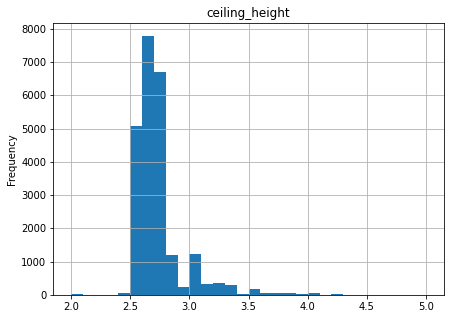

In [16]:
sale_apart['ceiling_height'].plot(title = "ceiling_height", 
                                  kind = 'hist', 
                                  bins = 30, range=(2,5), 
                                  grid=True, 
                                  figsize = (7,5))
sale_apart['ceiling_height'].describe()

Столбец с апартаментами вероятно мог появиться не сразу с началом ведения записей, поэтому заменим все пропущенные значения на False. И поменяем тип данных на bool.

In [17]:
sale_apart['is_apartment'] = sale_apart['is_apartment'].astype('bool')
sale_apart['is_apartment'] = sale_apart['is_apartment'].fillna(False)

Заменим пропуски в kitchen_area с помощью медианы по категоризированному столбцу total_area. Допустим, что метраж кухни в среднем одинаково распределяется относительно общей площади квартиры. Процент пропущенных значений не такой большой, поэтому наши замененные значения не сильно исказят результаты. 

In [18]:
print(np.percentile(sale_apart['total_area'], q=[25,50,75]))
print(sale_apart['total_area'].max())
print(sale_apart['total_area'].min())

[40.  52.  69.9]
900.0
12.0


In [19]:
def income_area(i):
    if i <=40:
        return 'меньше 40 кв.м'
    elif 41 <= i <= 52:
        return "41-52 кв.м"
    elif 53 <= i <= 69.9:
        return '53-69.9 кв.м'
    return 'больше 70 кв.м'

sale_apart['income_area'] = sale_apart['total_area'].apply(income_area)
print(sale_apart['income_area'].value_counts())

больше 70 кв.м    6319
меньше 40 кв.м    6042
41-52 кв.м        5679
53-69.9 кв.м      5659
Name: income_area, dtype: int64


In [20]:
total_income_median = sale_apart.groupby(['income_area'])
sale_apart['kitchen_area'] = total_income_median.kitchen_area.apply(lambda x: x.fillna(x.median()))
print(sale_apart['kitchen_area'].isna().sum())

0


*airports_nearest, cityCenters_nearest, parks_nearest и ponds_nearest, parks_around3000, ponds_around3000*:

По *airports_nearest, cityCenters_nearest, parks_nearest и ponds_nearest*: данные рассчитывала система. Они могут отустствовать по причине того, что относительно конкретно взятого населенного пункта/точки искались расстояние в определенном радиусе. Если в пределах этого радиуса ни аэропорта, ни парков не было, то и указать в этом столбце системе было нечего. 

По *parks_around3000, ponds_around3000*: аналогично как и с parks_nearest и ponds_nearest - данные просто не были заполнены. Пропуски в них меняем на ноль.

Пропущенные значения в locality_name не будем трогать, причина не понятна, да и количество пропусков очень маленькое - близится к 0%.

In [21]:
sale_apart['ponds_around3000'] = sale_apart['ponds_around3000'].fillna(0)
sale_apart['parks_around3000'] = sale_apart['parks_around3000'].fillna(0)
sale_apart['parks_nearest'] = sale_apart['parks_nearest'].fillna(0)
sale_apart['ponds_nearest'] = sale_apart['ponds_nearest'].fillna(0)
sale_apart['cityCenters_nearest'] = sale_apart['cityCenters_nearest'].fillna(0)
sale_apart['airports_nearest'] = sale_apart['airports_nearest'].fillna(0)
sale_apart['living_area'] = sale_apart['living_area'].fillna(0)

Заменим типы данных и посмотрим сколько памяти сэкономим:

In [22]:
sale_apart['days_exposition'] = sale_apart['days_exposition'].astype('uint16')
sale_apart['balcony'] = sale_apart['balcony'].astype('uint8')
sale_apart['floors_total'] = sale_apart['floors_total'].astype('uint8')
sale_apart['last_price'] = sale_apart['last_price'].astype('uint32')
sale_apart['ponds_around3000'] = sale_apart['ponds_around3000'].astype('uint8')
sale_apart['parks_around3000'] = sale_apart['parks_around3000'].astype('uint8')
sale_apart['parks_nearest'] = sale_apart['parks_nearest'].astype('uint16')
sale_apart['ponds_nearest'] = sale_apart['ponds_nearest'].astype('uint16')
sale_apart['cityCenters_nearest'] = sale_apart['cityCenters_nearest'].astype('uint16')
sale_apart['airports_nearest'] = sale_apart['airports_nearest'].astype('uint16')

In [23]:
sale_apart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  uint32        
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  uint8         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

In [24]:
#проверяем пропуски по всем столбцам 

display(sale_apart.isnull().sum())

total_images             0
last_price               0
total_area               0
first_day_exposition     0
rooms                    0
ceiling_height           0
floors_total             0
living_area              0
floor                    0
is_apartment             0
studio                   0
open_plan                0
kitchen_area             0
balcony                  0
locality_name           49
airports_nearest         0
cityCenters_nearest      0
parks_around3000         0
parks_nearest            0
ponds_around3000         0
ponds_nearest            0
days_exposition          0
income_floors            0
income_area              0
dtype: int64

**Выводы**

В предобработке данных мы обнаружили некоторые ошибки и пропущенные значения, от которых благополучно избавились в процессе.Был заменен тип данных, где посчитали это необходимым. Например, количество балконов и этажей перевели в целочисленный тип, потому что там не нужны десятые и сотые. 

Заменили пропуски на ноль в таких столбцах как:

- living_area - процент пропусков относительно мал и нам неоткуда взять точную информацию о жилой площади определенной квартиры в определенном населенном пункте

- locality_name - здесь процент пропущенных значений совсем мизерный и никак не отразится на резульататах исследования

- airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest - эти данные рассчитывала система. Они могут отустствовать по причине того, что относительно конкретно взятого населенного пункта/точки искались расстояние в определенном радиусе. Если в пределах этого радиуса ни аэропорта, ни парков не было, то и указать в этом столбце системе было нечего. 


## Расчёты и добавление результатов в таблицу

Посчитаем и добавим в таблицу цену квадратного метра (отношение цены на момент снятия с публикации и площади квартиры в квадратных метрах). Для удобства изменим тип данных на int.

In [25]:
sale_apart['price_meter'] = sale_apart['last_price'] / sale_apart['total_area']

In [26]:
sale_apart['price_meter'] = sale_apart['price_meter'].astype('int')

Посчитаем день недели, месяц и год публикации объявления и добавим в таблицу. 

In [27]:
sale_apart['weekday_exposition'] = sale_apart['first_day_exposition'].dt.weekday

sale_apart['month_exposition'] = sale_apart['first_day_exposition'].dt.month

sale_apart['year_exposition'] = sale_apart['first_day_exposition'].dt.year

Посчитаем этаж квартиры, где вариантами будут первый этаж, последний и другой. Мы уже проводили категоризацию этой переменной, но задание требует других категорий, поэтому делаем. И также добавляем новый столбец в таблицу.

In [28]:
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    return 'другой'
      
sale_apart['floor_category'] = sale_apart.apply(floor_category, axis = 1)

In [29]:
sale_apart['floor_category'].value_counts()

другой       17443
последний     3339
первый        2917
Name: floor_category, dtype: int64

Посчитаем соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [30]:
sale_apart['useful_area_ratio'] = sale_apart['living_area'] / sale_apart['total_area']

sale_apart['kitchen_area_ratio'] = sale_apart['kitchen_area'] / sale_apart['total_area']

**Выводы**

Провели все необходимые расчеты и добавили новые данные в таблицу. Эти расчеты нам понадобятся дальше в исследовательском анализе данных. 



## Исследовательский анализ данных

- **Изучим следующие параметры: площадь, цена, число комнат, высота потолков.**

По каждому параметру строим гистограмму и смотрим информацию о распределении данных с помощью метода describe().  

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

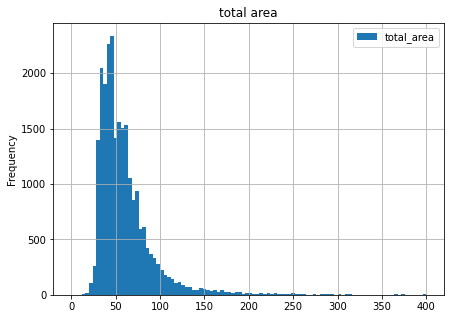

In [31]:
sale_apart.plot(title = 'total area', 
                y = 'total_area', 
                kind = 'hist', 
                bins = 100, 
                grid=True, 
                figsize = (7,5), 
                range = (0,400))
sale_apart['total_area'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

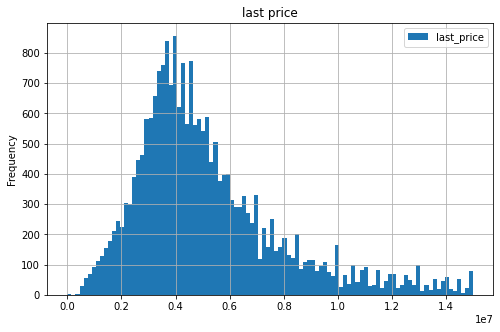

In [32]:
sale_apart.plot(title = 'last price', 
                y = 'last_price', 
                kind = 'hist', 
                bins = 100, 
                grid=True, 
                range = (0,15000000), 
                figsize = (8,5))
sale_apart['last_price'].describe()

count    23699.000000
mean         2.070636
std          1.078405
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

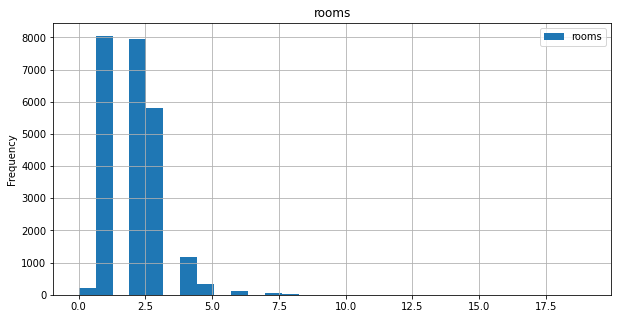

In [33]:
sale_apart.plot(title = 'rooms', 
                y = 'rooms', 
                kind = 'hist', 
                bins = 30, 
                grid=True, 
                figsize = (10,5))
sale_apart['rooms'].describe()

count    23699.000000
mean         2.721512
std          0.988999
min          1.000000
25%          2.600000
50%          2.600000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

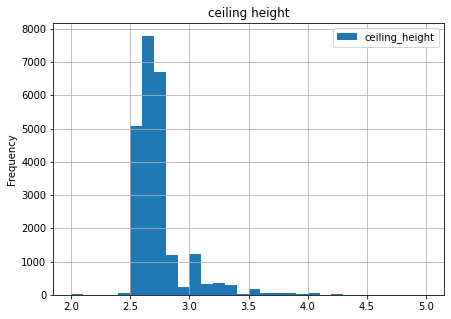

In [34]:
sale_apart.plot(title = 'ceiling height', 
                y = 'ceiling_height', 
                kind = 'hist', 
                bins = 30, 
                range = (2,5), 
                grid=True, 
                figsize = (7,5))
sale_apart['ceiling_height'].describe()

**Выводы**

Исходя из гистограм и с помощью метода describe() мы узнали много интересных данных о переменных площади квартир, цены, числе комнат и высоте потолков.

Как показало распределение общая площадь колеблется от 12 до 900 кв.м. (это конечно мощно), среднее значение 60, а медиана 52 кв.м.

Цены на недвижимость имеют среднее значение в 6,5 млн. руб. Минимальная стоимость составила 12190 руб, а максимальная - 7,6 млн.руб. Значения вывелись в экспоненциальной записи чисел, поэтому минимальная стоимость является выбросом, с которым будем дальше разбираться.

Количество комнат колеблется от 1 до 19. Больше всего однокомнатных квартир. Минимальное значение - 0 комнат. Максимальное значение может предполагать общежитие или отель, гостиницу. 

Высота потолков в среднем составляет 2,77 м, медиана 2,65 м. Минимальное значение у высоты потолков - 1 м, а максимальное - 100. Скорее всего это выбросы, от которых дальше нужно будет избавиться. 

Во всех данных есть неадекватные значения или выбросы, наподобе 0 комнат, высоты потолков в 1 или 100 метров, а также цена квартиры в 12190 рублей.

- **Изучим время продажи квартиры. Опишем, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?**

In [35]:
sale_apart['days_exposition'].describe()

count    23699.000000
mean       156.608844
std        213.546873
min          0.000000
25%         22.000000
50%         74.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [36]:
sale_apart['days_exposition'].median()

74.0

В среднем квартира продается за 156 дней. Медиана равна 74 дня. Но если посмотреть на минимальное и максимальное значение - 0 дней и 1580 дней соотетственно, то можно отметить, что из-за выбросов данные могут быть искажены. Подберемся ближе к времени продажи квартиры и построим диаграму размаха. 

Text(0, 0.5, 'frequency')

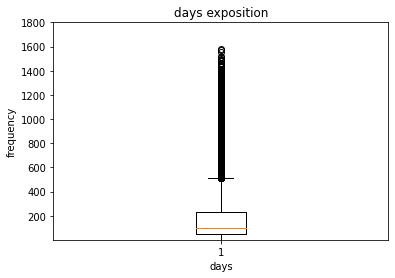

In [37]:
plt.boxplot(sale_apart[sale_apart['days_exposition']!=0]['days_exposition'])
plt.ylim( 1,1800)
plt.title("days exposition")
plt.xlabel("days")
plt.ylabel("frequency")

Выбросы замечены после значения в 500 дней. Все, что до 500 дней это граница нормального размаха. Построим гистограмму и посмотрим, что там. 

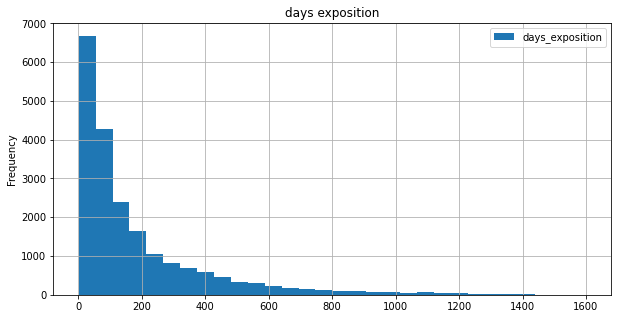

In [38]:
sale_apart.plot(title = 'days exposition', 
                y = 'days_exposition', 
                kind = 'hist', 
                bins = 30, 
                grid = True, 
                range = (1,1600), 
                figsize = (10,5))
plt.show()

Чаще всего квартиры продавались до 200 дней, а точнее закрывались объявления. Посмотрим данные за этот промежуток времени.

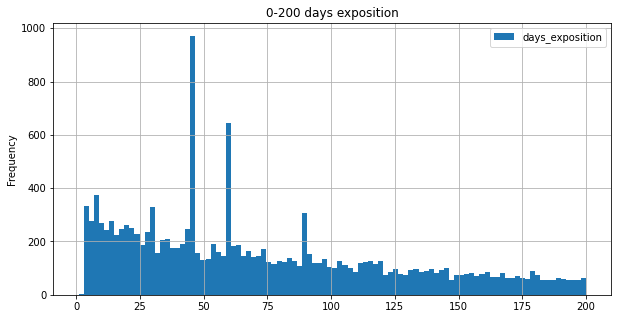

In [39]:
sale_apart.plot(title = '0-200 days exposition', 
                y = 'days_exposition', 
                kind = 'hist', 
                bins = 100, 
                grid = True, 
                range = (1,200), 
                figsize = (10,5))
plt.show()

Видим, что на определенный день происходит большая часть продаж квартир. Что это за дни? И почему именно они? 

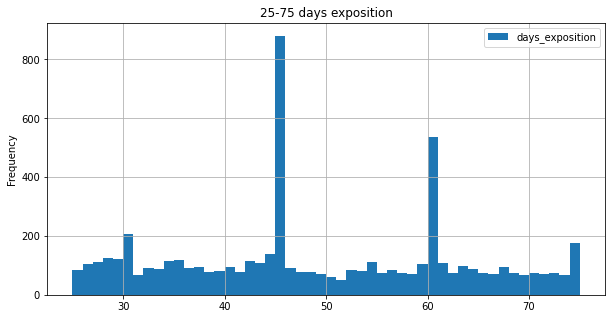

In [40]:
sale_apart.plot(title = '25-75 days exposition', 
                y = 'days_exposition', 
                kind = 'hist', 
                bins = 50, 
                grid = True, 
                range = (25,75), 
                figsize = (10,5))
plt.show()

На 45 и 60 дни происходили аномально частые закрытия объявлений. Квартиры может продавались и до закрытия объявления, поэтому нельзя сказать, что именно в эти дни происходили самые частые продажи. 

**Выводы**

Отвечая на поставленный вопрос "Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?", можно попробовать ответить исходя из диаграмы размаха. Все, что после 500 дней это выбросы, которые встречаются крайне редко. Значит все, что до 500 дней это считается быстрыми продажами, и все, что после 500 дней это долгие продажи. Но чаще всего люди успевают продать квартиру за полгода.

- **Уберем редкие и выбивающиеся значения. Опишем, какие особенности обнаружили.**

Отфильтруем данные от аномалий и запишем их в новую переменную. Уберем также нулевые значения, которыми мы заполнили пропуски.

In [41]:
good_sale_apart = sale_apart.query('days_exposition != 45 and days_exposition != 60 and days_exposition != 0')

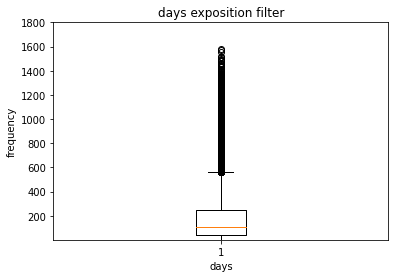

In [43]:
plt.boxplot(good_sale_apart['days_exposition'])
plt.ylim(1,1800)
plt.title("days exposition filter")
plt.xlabel("days")
plt.ylabel("frequency")
plt.show()

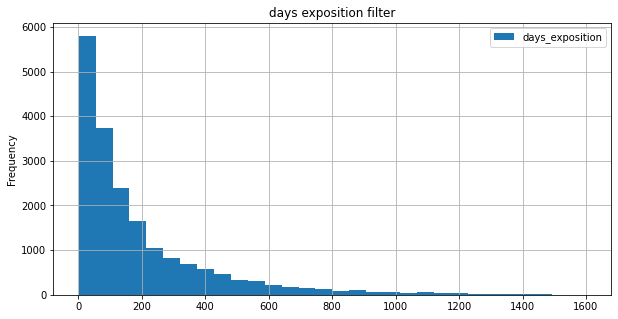

In [44]:
good_sale_apart.plot(title = 'days exposition filter', 
                     y = 'days_exposition', 
                     kind = 'hist', 
                     bins = 30, 
                     grid = True, 
                     range = (1,1600), 
                     figsize = (10,5))
plt.show()

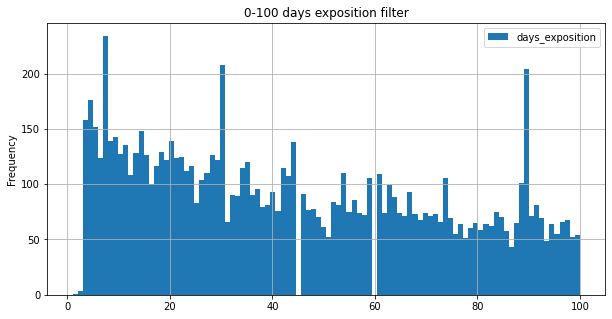

In [45]:
good_sale_apart.plot(title = '0-100 days exposition filter', 
                     y = 'days_exposition', 
                     kind = 'hist', 
                     bins = 100, 
                     grid = True, 
                     range = (1,100), 
                     figsize = (10,5))
plt.show()

Как оказалось, надо было выделить еще и другие аномальные дни - 7, 30 и 90. Уберем и их.

In [46]:
good_sale_apart = sale_apart.query('days_exposition != 45 and days_exposition != 60 and days_exposition != 0 and days_exposition != 7 and days_exposition != 30 and days_exposition != 90 ')

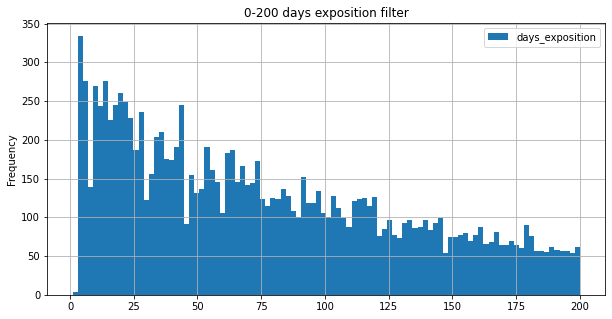

In [47]:
good_sale_apart.plot(title = '0-200 days exposition filter', 
                     y = 'days_exposition', 
                     kind = 'hist', 
                     bins = 100, 
                     grid = True, 
                     range = (1,200), 
                     figsize = (10,5))
plt.show()

Отлично,теперь проверим, как изменились описательные статистики и диаграма размаха.

In [48]:
good_sale_apart['days_exposition'].describe()

count    18454.000000
mean       195.803349
std        226.760010
min          1.000000
25%         44.000000
50%        114.000000
75%        259.000000
max       1580.000000
Name: days_exposition, dtype: float64

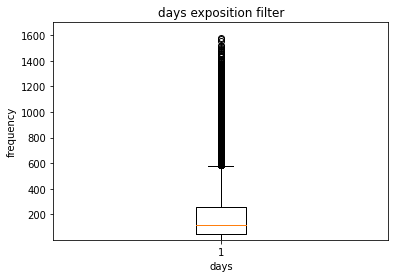

In [50]:
plt.boxplot(good_sale_apart['days_exposition'])
plt.ylim(1,1700)
plt.title("days exposition filter")
plt.xlabel("days")
plt.ylabel("frequency")
plt.show()

**Выводы**

В очищенных данных мы получили большие значение медианы и среднего значения по сравнению с медианой и средним до обработки - 114 и 195 соответственно, вместо 74 и 156. Аналогично, теперь нормальные значения располагаются от 1 до 600 дней вместо от 1 до 500 дней.

- **Какие факторы больше всего влияют на стоимость квартиры? Изучим, зависит ли цена квадратного метра от общей площади квартиры, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучим зависимость от даты размещения: дня недели, месяца и года.**

- *Начнем с изучения зависимости цены квадратного метра от общей площади квартиры.*


In [51]:
pivot_table_total_area = sale_apart.pivot_table(index = 'total_area', 
                                                values = 'price_meter', 
                                                aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']

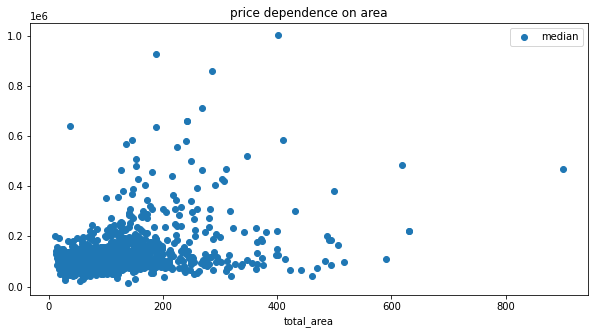

In [53]:
pivot_table_total_area.plot(title = 'price dependence on area', 
                            y = 'median', 
                            style = 'o', 
                            figsize = (10,5))
plt.show()

In [54]:
sale_apart['total_area'].corr(sale_apart['price_meter'])

0.30196014387792547

Так как корреляция 0,3, то мы можем говорить об очень слабой зависимости. То есть с увеличением квадратных метров в квартире, цена не сильно выше. Хотя это очень странно. 

- *Изучим зависимость цены квадратного метра от числа комнат*

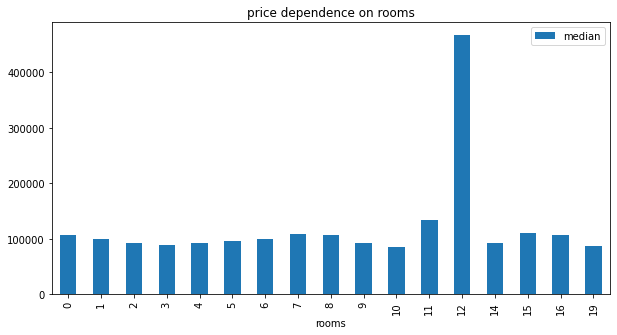

In [57]:
pivot_table_rooms = sale_apart.pivot_table(index = 'rooms', 
                                           values = 'price_meter', 
                                           aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.plot(title = 'price dependence on rooms', 
                       y = 'median', 
                       kind='bar', 
                       figsize = (10,5))
plt.show()

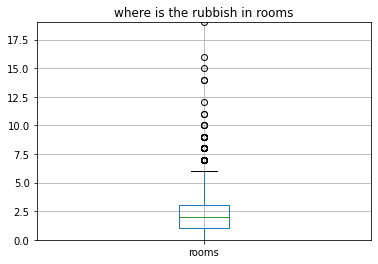

In [58]:
sale_apart.boxplot(column='rooms')
plt.ylim(0,19)
plt.title("where is the rubbish in rooms")
plt.show()

Все, что больше 7 комнат, считается выбросами. Избавимся от них и посмотрим на зависимость. 

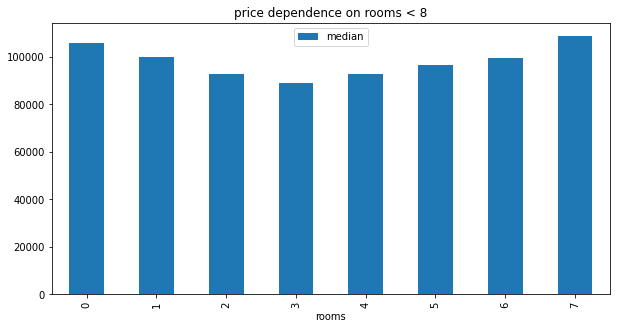

In [59]:
pivot_table_rooms.query('rooms <=7').plot(title = 'price dependence on rooms < 8', 
                                          y = 'median', 
                                          kind='bar', 
                                          figsize = (10,5)) 
plt.show()

In [60]:
pivot_table_rooms.query('count > 50').sort_values('median', ascending = False)

,mean,count,median
rooms,,,
7,163569.491525,59,108827.0
0,108512.730964,197,105555.0
1,100817.830993,8047,100000.0
6,140718.342857,105,99411.0
5,126749.889571,326,96516.5
2,95489.207557,7940,92796.0
4,110331.160169,1180,92666.0
3,97150.694358,5814,88983.0


In [61]:
sale_apart['rooms'].corr(sale_apart['price_meter'])

0.05541949967059219

**Выводы**

Зависимость вообще очень слабая. Цена квадратного метра не зависит от количества комнат. Единственное, что можно отметить, так это, что стоимость квадратного метра становится чуть ниже, когда количество комнат в квартире - 3. 

- *Изучим зависимость цены квадратного метра от этажа (первого или последнего)*

In [63]:
pivot_table_floor_category = sale_apart.pivot_table(index = 'floor_category', 
                                                    values = 'price_meter', 
                                                    aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_category.columns = ['mean', 'count', 'median']

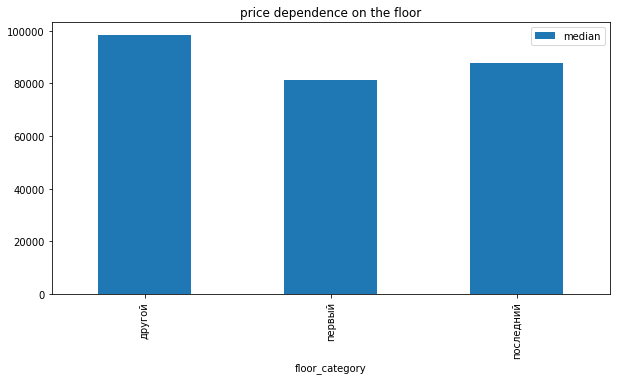

In [64]:
pivot_table_floor_category.plot(title = 'price dependence on the floor', 
                                y = 'median', 
                                kind='bar', 
                                figsize = (10,5))
plt.show()

In [65]:
pivot_table_floor_category

,mean,count,median
floor_category,,,
другой,103486.150204,17443,98290
первый,81983.111759,2917,81223
последний,93420.068284,3339,87777


**Выводы**

На последнем этаже цена квадратного метра выше, чем на первом, но ниже, чем на других этажах.

- *Изучим зависимость цены квадратного метра от удаленности от центра*

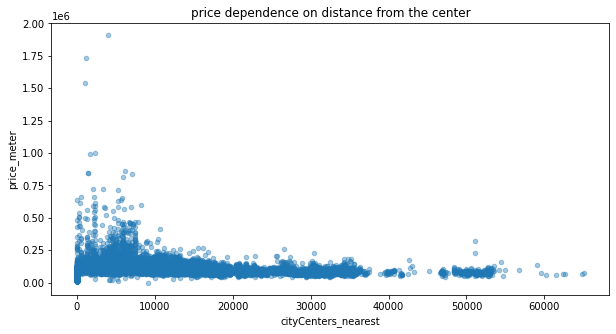

In [66]:
sale_apart.plot(title = 'price dependence on distance from the center', 
                kind = 'scatter', 
                y = 'price_meter', 
                x = 'cityCenters_nearest', 
                alpha = 0.4, 
                figsize = (10,5))
plt.show()

In [67]:
sale_apart['cityCenters_nearest'].corr(sale_apart['price_meter'])

0.03461458166050166

**Выводы**

Если рост одной величины связан с уменьшением другой, коэффициент отрицательный. Значит при увеличении цены квадратного метра, уменьшается удаленность от центра города. Так и показывает коэффициент корреляции -0.3.

- *Изучим зависимость цены квадратного метра от даты размещения: дня недели.*

In [68]:
pivot_table_weekday_exposition = sale_apart.pivot_table(index = 'weekday_exposition', 
                                                        values = 'price_meter', 
                                                        aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']

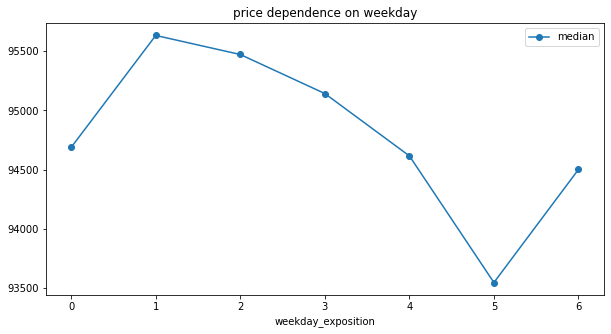

In [69]:
pivot_table_weekday_exposition.plot(title = 'price dependence on weekday', 
                                    y = 'median', 
                                    figsize = (10,5), 
                                    style = 'o-')
plt.show()

In [70]:
pivot_table_weekday_exposition.sort_values('median', ascending = False)

,mean,count,median
weekday_exposition,,,
1,99734.089410,4183,95634.0
2,99616.731002,3974,95473.0
3,100162.466356,4295,95143.0
0,99437.994463,3612,94688.0
4,99011.697000,4000,94616.0
6,97707.917010,1699,94501.0
5,99017.722107,1936,93545.5


**Выводы**

Во вторник размещают объявления с самой высокой стоимостью квадратного метра, в то время как в субботу с самой низкой стоимостью. Вообще, в рабочие дни начинается активность по просмотру объявлений. Это может быть связано с рабочими днями, когда люди сконцентрированы и не отвлекаются на отдых с семьей в выходные. 

- *Изучим зависимость цены квадратного метра от даты размещения: месяца.*

In [71]:
pivot_table_month_exposition = sale_apart.pivot_table(index = 'month_exposition', 
                                                      values = 'price_meter', 
                                                      aggfunc = ['mean', 'count', 'median'])
pivot_table_month_exposition.columns = ['mean', 'count', 'median']

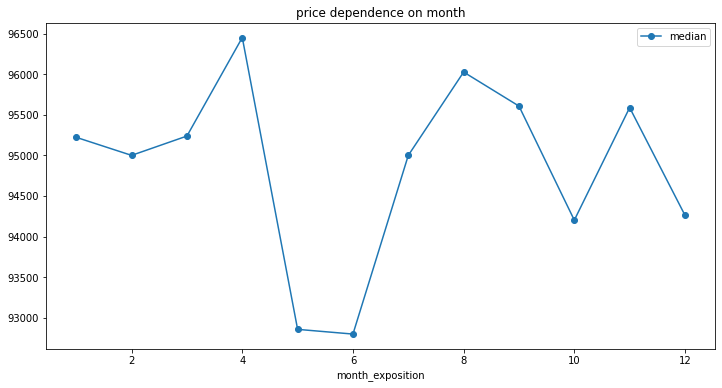

In [72]:
pivot_table_month_exposition.plot(title = 'price dependence on month', 
                                  y = 'median', 
                                  figsize = (12,6), 
                                  style = 'o-')
plt.show()

In [73]:
pivot_table_month_exposition.sort_values('median', ascending = False)

,mean,count,median
month_exposition,,,
4,101948.567045,2379,96451
8,100110.094037,1744,96026
9,100463.814740,1981,95607
11,99230.427246,2371,95588
3,98972.768844,2587,95238
1,99862.139333,1500,95222
2,98768.292045,2640,95000
7,99625.190560,1695,95000
12,99574.280926,1641,94262


**Выводы**

Чаще всего цена квадратного метра подскакивает в апреле и в августе. Самая низкая стоимость в мае и июне. В начале лета у многих начинаются отпуска, поэтому и спрос на квартиры становится ниже.

- *Изучим зависимость цены квадратного метра от даты размещения: года.*

In [74]:
pivot_table_year_exposition = sale_apart.pivot_table(index = 'year_exposition', 
                                                     values = 'price_meter', 
                                                     aggfunc = ['mean', 'count', 'median'])
pivot_table_year_exposition.columns = ['mean', 'count', 'median']

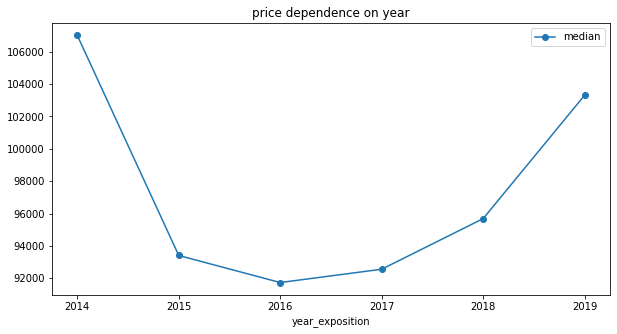

In [75]:
pivot_table_year_exposition.plot(title = 'price dependence on year', 
                                 y = 'median', 
                                 figsize = (10,5), 
                                 style = 'o-')
plt.show()

In [76]:
pivot_table_year_exposition.sort_values('median', ascending = False)

,mean,count,median
year_exposition,,,
2014,124830.000000,137,107000.0
2019,107123.332060,2879,103305.0
2018,97773.107290,8519,95689.0
2015,104613.756507,1191,93414.0
2017,97621.434188,8190,92564.5
2016,98321.900467,2783,91743.0


**Выводы**

Пик дорогих продаж недвижимости был в 2014 году, затем на протяжении двух лет цена за квадратный метр падала. В 2014 году был кризис, возможно это спад цен связан именно с ним. Затем после 2016 года цены вновь пошли вверх. 

- **Выберем 10 населённых пунктов с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью жилья.**

In [77]:
toplocality_pivot_table = sale_apart.pivot_table(index = 'locality_name', 
                                                 values = 'price_meter', 
                                                 aggfunc=['count', 'mean'])
toplocality_pivot_table.columns = ['count', 'mean']
toplocality_pivot_table = toplocality_pivot_table.sort_values('count', ascending = False).head(10)

In [78]:
toplocality_pivot_table

,count,mean
locality_name,,
Санкт-Петербург,15721,114848.565231
Мурино,556,85681.305755
Шушары,440,78676.904545
Всеволожск,398,68654.007538
Пушкин,369,103125.373984
Колпино,338,75424.150888
Парголово,327,90175.489297
Гатчина,307,68745.693811
Кудрово,299,92473.086957


In [79]:
toplocality_pivot_table[toplocality_pivot_table['mean']==toplocality_pivot_table['mean'].max()]

,count,mean
locality_name,,
Санкт-Петербург,15721,114848.565231


In [80]:
toplocality_pivot_table[toplocality_pivot_table['mean']==toplocality_pivot_table['mean'].min()]

,count,mean
locality_name,,
Выборг,237,58141.489451


**Выводы**

Наибольшее число объявлений собрали такие населенные пункты как Санкт_Петербург, поселок Мурино, поселок Шушары, Всеволожск, Пушкин, Колпино, поселок Парголово, Гатчина, деревня Кудрово и Выборг. Максимальная цена за квадратный метр, логично, в Санкт_петербурге, а минимальная в Выборге. 

- **Выясним, какая область входит в центр Санкт-Петербурга. А также посмотрим, как цена зависит от удалённости от центра.**

In [81]:
sale_apart['cityCenters_nearest_km'] = sale_apart['cityCenters_nearest']/1000
sale_apart['cityCenters_nearest_km'] = sale_apart['cityCenters_nearest_km'].fillna(999999)
sale_apart['cityCenters_nearest_km'] = sale_apart['cityCenters_nearest_km'].astype('int')

In [82]:
pivot_table_km = sale_apart.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km !=999999').pivot_table(index = 'cityCenters_nearest_km', 
                                                                                                                        values = 'price_meter', 
                                                                                                                        aggfunc = 'mean')

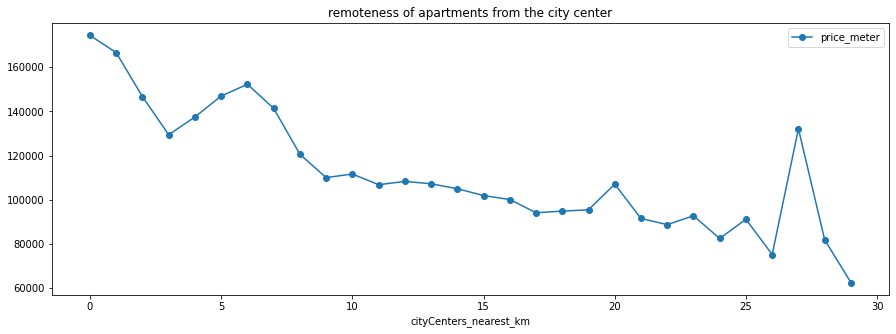

In [83]:
pivot_table_km.plot(title = 'remoteness of apartments from the city center', 
                    y = 'price_meter', 
                    figsize = (15,5), 
                    style = 'o-')
plt.show()

In [84]:
pivot_table_km

,price_meter
cityCenters_nearest_km,
0,174401.571429
1,166603.312500
2,146662.420195
3,129415.891635
4,137475.039691
5,146978.789337
6,152277.455319
7,141399.287469
8,120580.929851


**Выводы**

График показывает нам, что цены на квадратный метр дороже естественно в самом центре, в 5 км от центра. Есть еще пик цен в 27 км от центра. Возможно там находится какой-то исторический район или город, где проживание подороже. График сильно меняется после 9 км - там цены постоянно падают, кропе пик в 20 км и в 27 км. 

- **Выделим сегмент квартир в центре. Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).**

In [85]:
#выделим квартиры в центре, беря за радиус 9 км

center_spb_data = sale_apart.query('cityCenters_nearest_km <= 9 and locality_name == "Санкт-Петербург"')

- *Зависимость стоимости квадратного метра от количества комнат.*

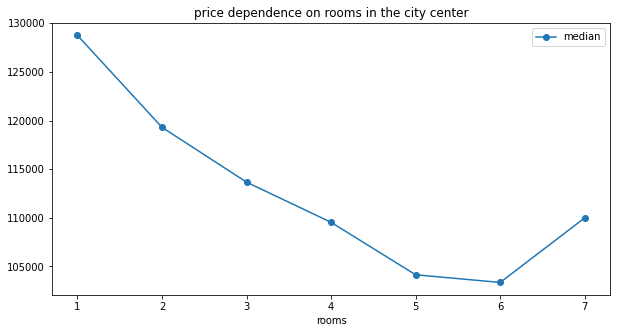

In [86]:
center_spb_rooms = center_spb_data.pivot_table(index = 'rooms', 
                                               values = 'price_meter', 
                                               aggfunc = ['mean', 'count', 'median'])
center_spb_rooms.columns = ['mean', 'count', 'median']
center_spb_rooms.query('count > 50').plot(y = 'median', 
                                          title = 'price dependence on rooms in the city center', 
                                          figsize = (10,5), 
                                          style = 'o-')
plt.show()

In [87]:
center_spb_rooms.query('count > 50').sort_values('median', ascending = False)

,mean,count,median
rooms,,,
1,137796.259557,994,128752.5
2,132857.374452,1597,119303.0
3,136376.988889,1530,113669.5
7,168247.553571,56,109996.0
4,138385.205172,580,109539.5
5,143547.412017,233,104150.0
6,151238.348315,89,103361.0


In [88]:
center_spb_data['rooms'].corr(center_spb_data['price_meter'])

0.03650992122767687

**Выводы**

График показывает, что в центре города, цена квадратного метра выше, чем меньше комнат. Но корреляция очень слабая, по ней нельзя говорить о какой-то зависимости. 

- *Зависимость стоимости квадратного метра от этажа.*

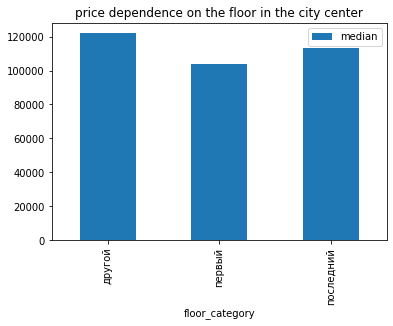

In [89]:
center_spb_floor_category = center_spb_data.pivot_table(index = 'floor_category', 
                                                        values = 'price_meter', 
                                                        aggfunc = ['mean', 'count', 'median'])
center_spb_floor_category.columns = ['mean', 'count', 'median']
center_spb_floor_category.plot(title = 'price dependence on the floor in the city center', 
                               y = 'median', 
                               kind='bar')
plt.show()

In [90]:
center_spb_floor_category

,mean,count,median
floor_category,,,
другой,139337.555112,3756,122222
первый,117696.693609,532,104050
последний,137618.333728,845,113333


**Выводы**

Также как и в общей выборке, на последнем этаже цена квадратного метра стоит дороже, чем на первом, но дешевле, чем на других этажах.  

- *Зависимость стоимости квадратного метра от удаленности от центра.*

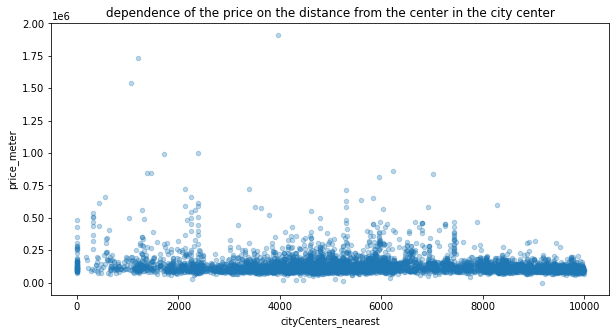

In [91]:
center_spb_data.plot(title= 'dependence of the price on the distance from the center in the city center',
                     kind = 'scatter', 
                     y = 'price_meter', 
                     x = 'cityCenters_nearest', 
                     alpha = 0.3, 
                     figsize = (10,5))
plt.show()

In [92]:
center_spb_data['cityCenters_nearest'].corr(center_spb_data['price_meter'])

-0.14754734379693676

**Выводы**

Так как мы и так рассматриваем центр, то зависимости никакой не наблюдается. Цена квадратного метра равномерно распределилась по всему радиусу в 9 км. 

- *Зависимость стоимости квадратного метра от дня недели размещения объявления.*

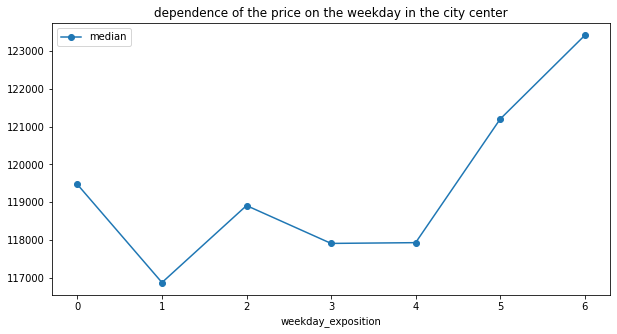

In [93]:
center_spb_weekday_exposition = center_spb_data.pivot_table(index = 'weekday_exposition', 
                                                            values = 'price_meter', 
                                                            aggfunc = ['mean', 'count', 'median'])
center_spb_weekday_exposition.columns = ['mean', 'count', 'median']
center_spb_weekday_exposition.plot(title = 'dependence of the price on the weekday in the city center', 
                                   y = 'median', 
                                   figsize = (10,5), 
                                   style = 'o-')
plt.show()

In [94]:
center_spb_weekday_exposition.sort_values('median', ascending = False)

,mean,count,median
weekday_exposition,,,
6,136283.271605,324,123402.0
5,145386.288360,378,121196.0
0,137823.069620,790,119470.5
2,135621.423299,867,118915.0
4,134633.243560,854,117936.5
3,137104.442495,1026,117916.5
1,135382.825503,894,116884.5


**Выводы**

В центре получилась другая ситуация в отличие от всей выборки. Меньше всего объявлений во вторник и в принципе в будни, а вот в субботу и воскресенье самый ажиотаж на рынке недвижимости. 

- *Зависимость стоимости квадратного метра от месяца размещения объявления.*

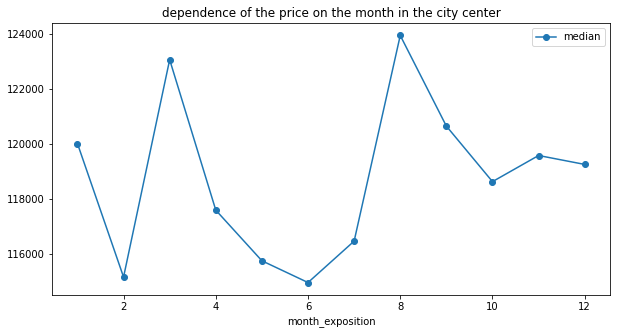

In [95]:
center_spb_month_exposition = center_spb_data.pivot_table(index = 'month_exposition', 
                                                          values = 'price_meter', 
                                                          aggfunc = ['mean', 'count', 'median'])
center_spb_month_exposition.columns = ['mean', 'count', 'median']
center_spb_month_exposition.plot(title = 'dependence of the price on the month in the city center', 
                                 y = 'median', 
                                 figsize = (10,5), 
                                 style = 'o-')
plt.show()

In [96]:
center_spb_month_exposition.sort_values('median', ascending = False)

,mean,count,median
month_exposition,,,
8,138854.021448,373,123958.0
3,136520.393357,572,123076.5
9,137353.909722,432,120662.5
1,137860.870662,317,120030.0
11,135146.327083,480,119594.0
12,140308.606936,346,119269.5
10,133336.350114,437,118644.0
4,142787.173570,507,117608.0
7,136205.657500,400,116481.5


**Выводы**

В феврале и мае меньше всего объявлений приходится на квартиры, а вот в марте и июле самый пик. Хотя в общей выборке в начале лета было меньше всего объявлений и мы предположили, что это из-за отпусков, когда люди разъезжаются на моря, по гостиницам и им не до купли-продажи квартиры. 

- *Зависимость стоимости квадратного метра от года размещения объявления.*

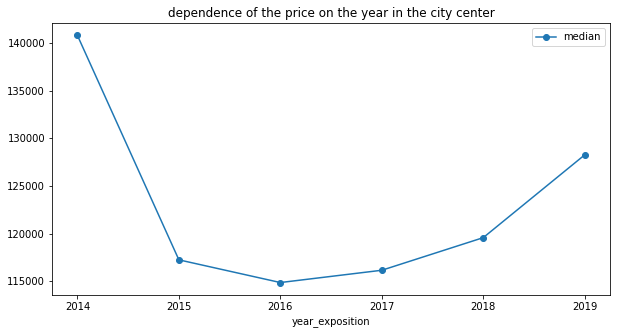

In [97]:
center_spb_year_exposition = center_spb_data.pivot_table(index = 'year_exposition', 
                                                         values = 'price_meter', 
                                                         aggfunc = ['mean', 'count', 'median'])
center_spb_year_exposition.columns = ['mean', 'count', 'median']
center_spb_year_exposition.plot(title = 'dependence of the price on the year in the city center', 
                                y = 'median', 
                                figsize = (10,5), 
                                style = 'o-')
plt.show()

In [98]:
center_spb_year_exposition.query('count > 50').sort_values('median', ascending = False)

,mean,count,median
year_exposition,,,
2019,146258.907767,618,128251.5
2018,132987.091636,1626,119570.0
2015,139201.231738,397,117241.0
2017,135599.704353,1769,116150.0
2016,136907.040996,683,114861.0


**Выводы**

Аналогично общей выборке после 2014 года цены на квартиры начали падать, скорее всего из-за кризиса. Спад продолжался 2 года, затем после 2016 года цены вновь начали расти. 

## Общий вывод

Анализ данных начался с их обработки. Были обнаружены пропущенные значения и ошибки, от которых мы благополучно избавились и обосновали тот или иной метод замены значений. Были проведены необходимые рассчеты, которые понадобились нам в исследовательском анализе данных. Например, цена за один квадратный метр, день недели, месяц и год публикации объявления о продаже квартиры, соотношение жилой и общей площади и т.д.

Как показало распределение общая площадь колеблется от 12 до 900 кв.м.(выбросы от которых мы избавились). Цены на недвижимость имеют среднее значение в 6,5 млн. руб. Минимальная стоимость составила 12190 руб, а максимальная - 7,6 млн.руб. 
Количество комнат колеблется от 1 до 19. Больше всего однокомнатных квартир. Высота потолков в среднем составляет 2,77 м. Минимальное значение у высоты потолков - 1 м, а максимальное - 100. 

Во всех данных были неадекватные значения или выбросы, наподобе 0 комнат, высоты потолков в 1 или 100 метров, а также цена квартиры в 12190 рублей. По ходу работы мы избавлялись от этих выбросов, чтобы результаты были более качественными и надежными. 

Отвечая на поставленный вопрос "Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?", можно попробовать ответить исходя из диаграмы размаха, в которой мы убрали все аномалии. Получилось, что после 600 дней это выбросы, которые встречаются крайне редко. Значит все, что до 600 дней это считается быстрыми продажами, и все, что после 600 дней это долгие продажи. Но чаще всего люди успевают продать квартиру за полгода.

Изучая зависимость между ценой квадратного метра и площадью квартиры, была выявлена слабый коэффициент корреляции (то есть с увеличением квадратных метров в квартире, цена не сильно выше). 
Аналогично с зависимостью цены от количества комнат - цена квадратного метра не зависит от количества комнат. Единственное, что можно отметить, так это, что стоимость квадратного метра становится чуть ниже, когда количество комнат в квартире - 3.
На последнем этаже цена квадратного метра выше, чем на первом, но ниже, чем на других этажах.
Результаты анализа показали, что при увеличении цены квадратного метра, уменьшается удаленность от центра города. То есть чем ближе квартира к центру, тем выше ее стоимость. Так и показывает коэффициент корреляции -0.3.

Во вторник размещают объявления с самой высокой стоимостью квадратного метра, в то время как в субботу с самой низкой стоимостью. Вообще, в рабочие дни начинается активность по просмотру объявлений. Месяцы активности в объявлениях - апрель и август, спад происходит в мае и июне. Пик дорогих продаж недвижимости был в 2014 году, затем на протяжении двух лет цена за квадратный метр падала. В 2014 году был кризис, возможно это спад цен связан именно с ним. Затем после 2016 года цены вновь пошли вверх. Аналогичную ситуацию показывает нам и выборка по центру города, то есть в радиусе 9 км. 

Наибольшее число объявлений собрали такие населенные пункты как Санкт-Петербург, поселок Мурино, поселок Шушары, Всеволожск, Пушкин, Колпино, поселок Парголово, Гатчина, деревня Кудрово и Выборг. Максимальная цена за квадратный метр, логично, в Санкт-Петербурге, а минимальная в Выборге.